# VO2 Max Prediction

This notebook demonstrates the process of predicting VO2 max using a dataset containing various physiological and training-related features.

**Steps:**

1.  **Setup and Imports**: Install necessary libraries and import modules.
2.  **Import and Inspect Dataset**: Load and explore the initial dataset.
3.  **Clean and Prepare Data**: Preprocess the data for analysis.
4.  **Model Training**: Train a machine learning model to predict VO2 max.
6.  **Model Evaluation**: Evaluate the performance of the trained model.
7.  **Inference**: Use the trained model to make predictions.
8.  **Sleep v/s VO2 Max Correlation**: Inspect the training data and plot correlation between Sleep and VO2 Max.

In [34]:
!pip -q install numpy pandas scikit-learn streamlit joblib matplotlib

import pandas as pd, numpy as np, joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

### Import and Inspect Dataset

In [ ]:
df = pd.read_csv("assets/vo2_real_augmented.csv")
df.head(), df.info(), df.shape

### Clean and Prepare Data

In [38]:
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# select relevant fields
cols = ["age","sex","height_cm","weight_kg","total_lean_mass","bmi","wbtpf","vo2max","resting_hr","max_hr","hr_recovery_1min","training_hours_week","avg_intensity","rest_days","sleep_hours_last_night","avg_sleep_hours_week","sleep_quality_score","resting_hr_delta"]
df = df[cols].dropna()



### Model Training

In [39]:
target = "vo2max"
features = [c for c in df.columns if c != target]
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target],
                                                    test_size=0.2, random_state=42)

In [ ]:
pre = ColumnTransformer([("num", StandardScaler(), features)], remainder="drop")
model = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
pipe = Pipeline([("pre", pre), ("rf", model)])
pipe.fit(X_train, y_train)

### Model Evaluation

In [41]:
preds = pipe.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, preds):.2f}, R²: {r2_score(y_test, preds):.3f}")

MAE: 4.13, R²: 0.603


### Model Export

In [42]:
os.makedirs("model", exist_ok=True)
joblib.dump(pipe, "model/vo2_predictor.joblib")
print("Saved → model/vo2_predictor.joblib")

Saved → model/vo2_predictor.joblib


### Inference

In [43]:
sample = df.sample(1, random_state=3).to_dict(orient="records")[0]
x = pd.DataFrame([sample])[features]
vo2_pred = pipe.predict(x)[0]
print("Predicted VO₂max:", round(vo2_pred,2), "ml/kg/min")

Predicted VO₂max: 35.03 ml/kg/min


In [44]:
def coaching_tip(vo2, sleep_quality, training_hours, hrr):
    tips = []
    if vo2 < 38:
        tips.append("Focus on easy aerobic runs (Zone 2) 3–4x/week.")
    elif vo2 < 48:
        tips.append("Add 1 interval session (e.g., 4×4min @ hard) each week.")
    else:
        tips.append("Maintain with polarized training (80/20 easy-to-hard).")

    if sleep_quality < 60:
        tips.append("Prioritize sleep hygiene (7–8h); avoid late caffeine.")
    if training_hours > 8:
        tips.append("Reduce volume 10–20% for recovery this week.")
    if hrr < 20:
        tips.append("Your 1-min HR recovery is low; keep intensities sub-threshold for 2–3 days.")

    return " ".join(tips) or "Keep up the good work!"

# quick smoke test
print(coaching_tip(45, 55, 6, 18))

Add 1 interval session (e.g., 4×4min @ hard) each week. Prioritize sleep hygiene (7–8h); avoid late caffeine. Your 1-min HR recovery is low; keep intensities sub-threshold for 2–3 days.


In [45]:
feature_order = features  # keep consistent

def predict_vo2(sample_dict):
    x = pd.DataFrame([sample_dict])[feature_order]
    vo2 = float(pipe.predict(x)[0])
    tip = coaching_tip(
        vo2=vo2,
        sleep_quality=float(sample_dict["sleep_quality_score"]),
        training_hours=float(sample_dict["training_hours_week"]),
        hrr=float(sample_dict["hr_recovery_1min"]),
    )
    return round(vo2, 2), tip

sample = df.sample(1, random_state=7).to_dict(orient="records")[0]
sample_vo2, sample_tip = predict_vo2(sample)
sample_vo2, sample_tip

(39.57, 'Add 1 interval session (e.g., 4×4min @ hard) each week.')

### Sleep v/s VO2 Max Correlation

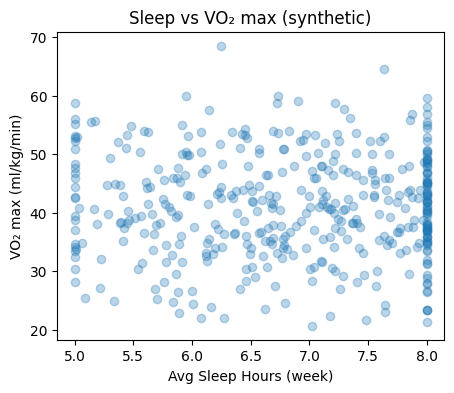

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.scatter(df["avg_sleep_hours_week"], df["vo2max"], alpha=0.3)
plt.xlabel("Avg Sleep Hours (week)")
plt.ylabel("VO₂ max (ml/kg/min)")
plt.title("Sleep vs VO₂ max (synthetic)")
plt.show()